## Практическое задание

1. К алгоритму kNN, реализованному на уроке, реализуйте добавление весов соседей по любому из показанных на уроке принципов.

In [287]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [288]:
X, y = load_iris(return_X_y=True)
# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [289]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

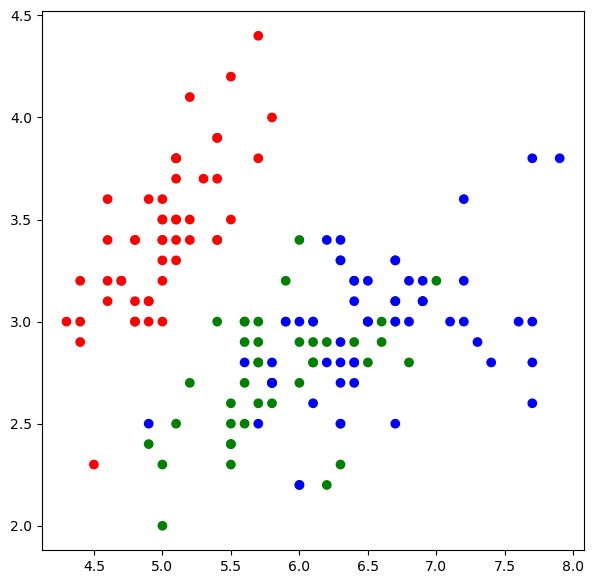

In [290]:
colors = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)


Функция *e_metrics* предназначена для вычисления евклидова расстояния между двумя точками в многомерном пространстве. Евклидово расстояние — это мера "прямолинейного" расстояния между двумя точками в пространстве, которая часто используется в задачах машинного обучения и анализа данных.

Применения функции e_metrics

**Кластеризация:**

В алгоритмах кластеризации, таких как k-means, евклидово расстояние используется для определения близости точек к центрам кластеров.
Расстояние между точками и центроидами кластеров вычисляется для назначения точек к соответствующим кластерам.

**Поиск ближайших соседей (k-NN):**

В алгоритме k ближайших соседей для классификации или регрессии вычисляется расстояние между тестовой точкой и всеми точками обучающей выборки.
Выбираются k ближайших соседей на основе минимального евклидова расстояния.

In [291]:
def e_metrics(X1, X2):
    """
    Вычисление евклидовых расстояний между всеми парами точек из X1 и X2.
    """
    return np.sqrt(np.sum((X1[:, np.newaxis] - X2) ** 2, axis=2))




In [292]:
def w_coeff_1(q, d):
    return q ** d # w(i) = q^i или w(i) = q^d в зависимости от того, что передать в параметре d

In [293]:
def w_coeff_2(q, d):
    return 1 / (d + q)**(1 + q)   # w(i) = 1 / (d+a)^b или  w(i) = 1 / i

In [294]:
def knn(x_train, y_train, x_test, k, q=1, wv=1):
    answers = []
    distances = e_metrics(x_test, x_train)
    weights = np.ones_like(distances)
    
    if wv == 1:
        weights = w_coeff_1(q, np.arange(1, distances.shape[1] + 1))
    elif wv == 2:
        weights = w_coeff_1(q, distances)
    elif wv == 3:
        weights = w_coeff_2(q, distances)
    elif wv == 4:
        weights = w_coeff_2(q, np.arange(1, distances.shape[1] + 1))
    
    weighted_distances = distances * weights
    sorted_indices = np.argsort(weighted_distances, axis=1)
    nearest_classes = y_train[sorted_indices[:, :k]]
    
    for i in range(nearest_classes.shape[0]):
        classes, counts = np.unique(nearest_classes[i], return_counts=True)
        answers.append(classes[np.argmax(counts)])
    
    return np.array(answers)

In [295]:
def accuracy(pred, y):
    '''доля правильных предсказаний'''
    return (sum(pred == y) / len(y))

In [296]:
# Настройка параметров
k = 15  # Количество соседей
q = 1  # Взвешивание
wv = 1  # Вариант расчета веса
h = .02  # Шаг сетки
pred = knn(X_train, y_train, X_test, k, q = q, wv=wv)
print(f'При k = {k} и q = {q} точность предсказания равна {accuracy(pred, y_test)}')

При k = 15 и q = 1 точность предсказания равна 0.8333333333333334


In [297]:
def visualize_kNN(X_train, y_train, X_test, y_test, k=3, q=1, wv=1):
    h = .02  # Шаг сетки
    # Определяем границы графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Получение предсказаний для всех точек сетки
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = knn(X_train, y_train, grid_points, k, q, wv)
    Z = Z.reshape(xx.shape)
    # Настройка цветовых карт
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap = ListedColormap(['red', 'blue', 'green'])
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.title(f"Трехклассовая kNN классификация при k = {k}, q = {q},\nвариант расчета веса {wv}")
    plt.show()

In [298]:
X_train.shape,X_test.shape

((120, 2), (30, 2))

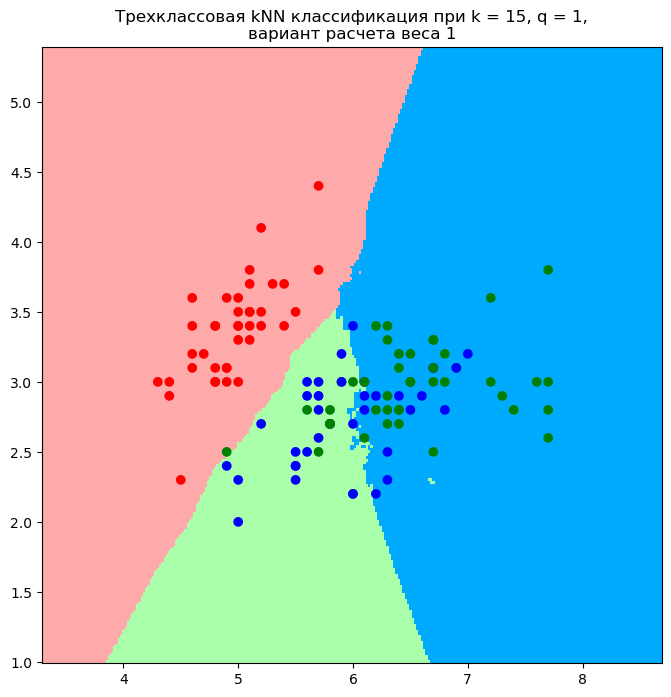

In [299]:
visualize_kNN(X_train, y_train, X_test, y_test, k, q, wv)


Подобрали *лучшие* значения k и q для максимальной точности, при этом wv (весовой коэффициент) в 3 и 4 варианте понижают точность

2. Напишите функцию по подсчёту метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и постройте график её зависимости от k (взять от 1 до 10) для выборки данных из этого урока.

In [300]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=500)

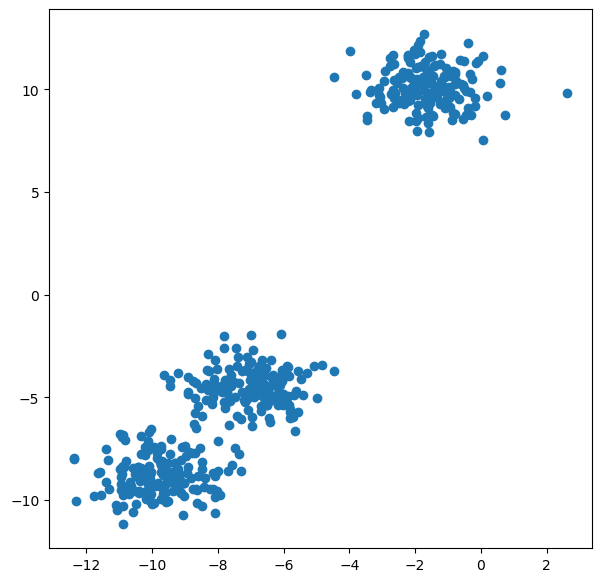

In [301]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [302]:
def kmeans(data, k, max_iterations, min_distance):
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]   
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)       
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()       
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)           
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False               
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    return old_centroids, classes

In [303]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [304]:
def kmeans_quality(centroids, clusters):
    k=0
    quality=0
    for c in centroids:
        for x in clusters[k]:
            quality += e_metrics(x, c)**2
        k+=1
    return quality

In [311]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(7,7))
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black', zorder=2)    
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])       
    plt.show()

In [312]:
# определим максимальное количество итераций
max_iterations = 10
# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4
# сразу определим известное нам количество кластеров
k = 3

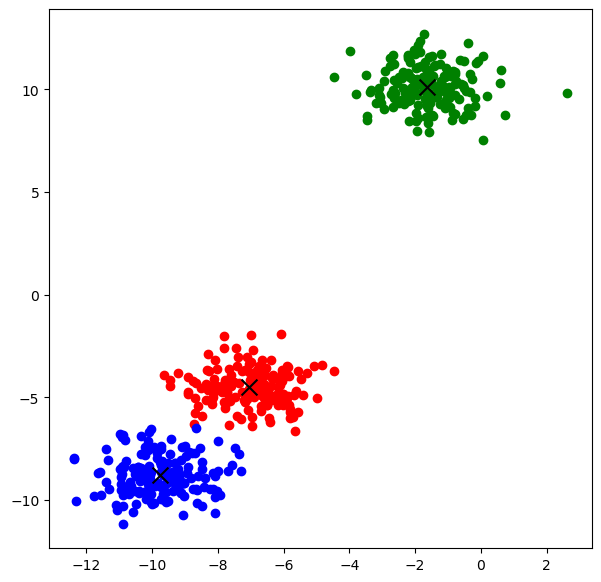

In [313]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [314]:
# Создаем пустой список для хранения значений метрики качества
kmeans_q = []
# Проходим по разным значениям k (количество кластеров)
for k in range(1, 11):
    # Выполняем кластеризацию методом k-means для текущего значения k
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    # Вычисляем метрику качества кластеризации
    quality = kmeans_quality(centroids, clusters)
    # Добавляем значение метрики качества в список
    kmeans_q.append(quality)


In [315]:
print('среднее квадратичные внутриклассовые расстояния:\n', np.round(kmeans_q))

среднее квадратичные внутриклассовые расстояния:
 [39590.  3079.   937.   829.   727.   613.   542.   480.   452.   424.]


Путем изменения числа кластеров k мы можем оценить, как это влияет на качество разделения данных на кластеры.
После выполнения кода, у нас будет список kmeans_q, в котором содержатся значения метрики качества для каждого значения k. Это позволяет нам выбрать оптимальное число кластеров, которое дает наилучшее разделение данных на кластеры.

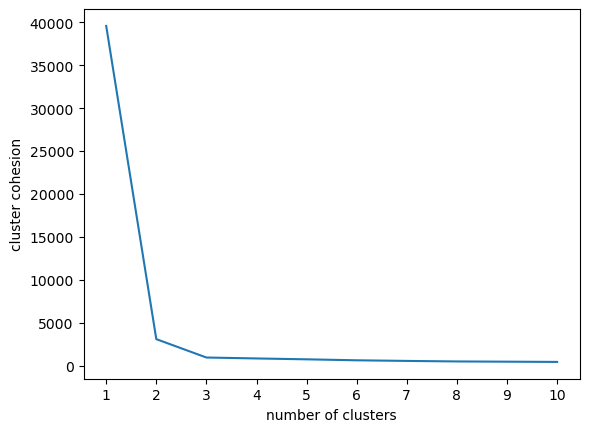

In [316]:
k=np.arange(10)
plt.xlabel('number of clusters')
plt.xticks(k+1)
plt.ylabel('cluster cohesion')
plt.plot(k+1,kmeans_q)

Из графика видно,что разделение более чем на 3 кластера не имеет большого смысла и значения